In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../Midterm"))
import copy
import datetime
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.metrics
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

['.ipynb_checkpoints', 'baseline_example.csv', 'column_description.csv', 'column_description_en.csv', 'Midterm-2nd place kernal.ipynb', 'Midterm.ipynb', 'ml100marathon-02-01.zip', 'sample_submission.csv', 'test.csv', 'test_offline.csv', 'train.csv', 'train_offline.csv', 'valid.csv', '擷取.JPG']


Data Checking

In [8]:
train_df = pd.read_csv('../Midterm/train_offline.csv')
test_df = pd.read_csv('../Midterm/test_offline.csv')

test_ids = test_df[['User_id','Coupon_id','Date_received']]

#Let's Check the shape of data first
print(f' training shape : {train_df.shape} ')
print(f' testing shape : {test_df.shape} ')

 training shape : (1160742, 7) 
 testing shape : (594142, 6) 


In [9]:
def CheckMissingVals(data):
    for col in data.columns:
        if np.sum(data[col].isnull()) != 0:
            print(f' Missing values in {col} : {np.sum(data[col].isnull())}')

print("Count of missing data in training dataset: ")
CheckMissingVals(train_df)
print('\n')
print("Count of missing data in testing dataset: ")
CheckMissingVals(test_df)

Count of missing data in training dataset: 
 Missing values in Coupon_id : 413773
 Missing values in Discount_rate : 413773
 Missing values in Distance : 69826
 Missing values in Date_received : 413773
 Missing values in Date : 704033


Count of missing data in testing dataset: 
 Missing values in Coupon_id : 287829
 Missing values in Discount_rate : 287829
 Missing values in Distance : 36177
 Missing values in Date_received : 287829


Deal with missing values

In [10]:
total_df = pd.concat([train_df, test_df], axis = 0)

In [11]:
DistanceFilling_UM = total_df.groupby(['User_id','Merchant_id'])['Distance'].mean().reset_index()
DistanceFilling_UM.columns = ['User_id','Merchant_id','DistanceFilling_UM']
DistanceFilling_U = total_df.groupby(['User_id'])['Distance'].mean().reset_index()
DistanceFilling_U.columns = ['User_id','DistanceFilling_U']
DistanceFilling_M = total_df.groupby(['Merchant_id'])['Distance'].mean().reset_index()
DistanceFilling_M.columns = ['Merchant_id','DistanceFilling_M']

total_df = pd.merge(total_df,DistanceFilling_UM,on = ['User_id','Merchant_id'], how = 'left')
total_df = pd.merge(total_df,DistanceFilling_U,on = ['User_id'], how = 'left')
total_df = pd.merge(total_df,DistanceFilling_M,on = ['Merchant_id'], how = 'left')
total_df.head(10)

,Coupon_id,Date,Date_received,Discount_rate,Distance,Merchant_id,User_id,DistanceFilling_UM,DistanceFilling_U,DistanceFilling_M
0,NaN,20160217.0,NaN,NaN,0.0,2632,1439408,0.0,0.142857,1.540000
1,8591.0,NaN,20160217.0,20:1,0.0,2632,1439408,0.0,0.142857,1.540000
2,1078.0,NaN,20160319.0,20:1,0.0,2632,1439408,0.0,0.142857,1.540000
3,7610.0,NaN,20160429.0,200:20,0.0,3381,1832624,0.0,0.000000,2.713991
4,11951.0,NaN,20160129.0,200:20,1.0,3381,2029232,1.0,0.200000,2.713991
5,9776.0,NaN,20160129.0,10:5,2.0,3381,2223968,2.0,2.000000,2.713991
6,12034.0,NaN,20160207.0,100:10,NaN,2099,73611,NaN,NaN,1.844211
7,5054.0,NaN,20160421.0,200:30,10.0,1569,163606,10.0,10.000000,6.163654
8,7802.0,NaN,20160130.0,200:20,10.0,4833,3273056,10.0,10.000000,6.927665
9,7610.0,NaN,20160412.0,200:20,2.0,3381,94107,2.0,2.000000,2.713991


In [12]:
def DistanceMissingFill(data):
    if np.isnan(data['Distance']):
        if not np.isnan(data['DistanceFilling_UM']):
            return int(data['DistanceFilling_UM'])
        elif not np.isnan(data['DistanceFilling_U']):
            return int(data['DistanceFilling_U'])
        elif not  np.isnan(data['DistanceFilling_M']):
            return int(data['DistanceFilling_M'])
    return data['Distance']

total_df['Distance'] = total_df.apply(DistanceMissingFill, axis = 1)

In [13]:
total_df = total_df.drop(['DistanceFilling_UM','DistanceFilling_U','DistanceFilling_M'], axis = 1)
train_df = total_df[:len(train_df)]
test_df = total_df[len(train_df):]

print("Count of missing data in training dataset: ")
CheckMissingVals(train_df)
print('\n')
print("Count of missing data in testing dataset: ")
CheckMissingVals(test_df)

Count of missing data in training dataset: 
 Missing values in Coupon_id : 413773
 Missing values in Date : 704033
 Missing values in Date_received : 413773
 Missing values in Discount_rate : 413773
 Missing values in Distance : 7471


Count of missing data in testing dataset: 
 Missing values in Coupon_id : 287829
 Missing values in Date : 594142
 Missing values in Date_received : 287829
 Missing values in Discount_rate : 287829
 Missing values in Distance : 980


Our goal is to predict the use of Coupon, so obviously, if the row doesnt have coupon_id, we dont need to consider such condition.

In [14]:
train_df = train_df[~train_df.Coupon_id.isnull()]
test_df = test_df[~test_df.Coupon_id.isnull()]

print(f' training shape after dropping unwant rows: {train_df.shape} ')
print(f' testing shape after dropping unwant rows: {test_df.shape} ')

 training shape after dropping unwant rows: (746969, 7) 
 testing shape after dropping unwant rows: (306313, 7) 


Also we only analysis the use of Coupon within 15 days after user received the Coupon. So If there are some users didnt use the Coupon within 15 days, we consider they didnt use the Coupon, which the probability of using Coupon is zero.

In [15]:
#Dont forget to drop date column in testing data
test_df = test_df.drop(['Date'], axis = 1)

In [16]:
def fifteenDaysChecking(data):
    if not np.isnan(data['Date']):
        #Means the user had used the coupon
        time_diff = pd.to_datetime(data['Date'], format = "%Y%m%d") - pd.to_datetime(data['Date_received'],
                                                                                   format = "%Y%m%d")
        if time_diff <= pd.Timedelta(15,'D'):
            return 1
    return 0
#This might will take a while
train_df['label'] = train_df.apply(fifteenDaysChecking, axis = 1)
print(train_df['label'].value_counts())
train_df.head(5)

0    710665
1     36304
Name: label, dtype: int64


,Coupon_id,Date,Date_received,Discount_rate,Distance,Merchant_id,User_id,label
1,8591.0,NaN,20160217.0,20:1,0.0,2632,1439408,0
2,1078.0,NaN,20160319.0,20:1,0.0,2632,1439408,0
3,7610.0,NaN,20160429.0,200:20,0.0,3381,1832624,0
4,11951.0,NaN,20160129.0,200:20,1.0,3381,2029232,0
5,9776.0,NaN,20160129.0,10:5,2.0,3381,2223968,0


In [17]:
train_df = train_df.drop(['Date'], axis = 1)
#Check the missing values again
print("Count of missing data in training dataset: ")
CheckMissingVals(train_df)
print('\n')
print("Count of missing data in testing dataset: ")
CheckMissingVals(test_df)

Count of missing data in training dataset: 
 Missing values in Distance : 7471


Count of missing data in testing dataset: 
 Missing values in Distance : 980


In [18]:
#Merge training & testing dataset for processing
train_label = train_df.label
train_df = train_df.drop(['label'], axis = 1)
total_df = pd.concat([train_df,test_df], axis = 0)
total_df.head(10)

,Coupon_id,Date_received,Discount_rate,Distance,Merchant_id,User_id
1,8591.0,20160217.0,20:1,0.0,2632,1439408
2,1078.0,20160319.0,20:1,0.0,2632,1439408
3,7610.0,20160429.0,200:20,0.0,3381,1832624
4,11951.0,20160129.0,200:20,1.0,3381,2029232
5,9776.0,20160129.0,10:5,2.0,3381,2223968
6,12034.0,20160207.0,100:10,1.0,2099,73611
7,5054.0,20160421.0,200:30,10.0,1569,163606
8,7802.0,20160130.0,200:20,10.0,4833,3273056
9,7610.0,20160412.0,200:20,2.0,3381,94107
11,7531.0,20160327.0,20:5,0.0,8390,253750


In [19]:
#Do a copy of original data , in case we do something wrong for the original data
temp_total_df = copy.deepcopy(total_df)

Feature Engineering

In [20]:
#Check the unique counts of each features
total_df.nunique()

Coupon_id          9738
Date_received       167
Discount_rate        45
Distance             11
Merchant_id        5599
User_id          510698
dtype: int64

date features

In [ ]:
#Convert Date_received to str type for datetime processing
total_df['Date_received'] = total_df['Date_received'].astype('int').astype('str')
#Convert Date_received to other time information
total_df['Date_received'] = total_df['Date_received'].apply(lambda x : datetime.datetime.strptime(x,"%Y%m%d"))
total_df['Month_received'] = total_df['Date_received'].apply(lambda x : datetime.datetime.strftime(x,"%m")).astype("int64")
total_df['Day_received'] = total_df['Date_received'].apply(lambda x : datetime.datetime.strftime(x,"%d")).astype("int64")

total_df.head(10)

In [ ]:
total_df['Month_Cycle'] = total_df.Day_received.map(lambda x : 1 if x <= 15 else 0)

In [ ]:
# Record the total days to June
def set2June(data):
    if data['Month_received'] < 6:
        return (6-data['Month_received'])*30 - data['Day_received']
    return 1
        
total_df['CloseToJune'] = total_df.apply(set2June , axis = 1)

Discount features

In [ ]:
#Let`s check what values in discount_rate feature
total_df.Discount_rate.value_counts()

From discount_rate feautre, we can see that there are two types of discount. One of them is directly discount and another is the discount that user's consumption need to reach certain price.

In [22]:
total_df['DiscountType'] = total_df.Discount_rate.map(lambda x: 1 if (':' in x) else 0)
total_df.DiscountType.value_counts()

1    1020010
0      33272
Name: DiscountType, dtype: int64

I would like to add threes feature from DiscountType. 

record what price need to reach that allow to get discount 
record when the price reach to discount, how much money can be discount 
record the discount ratio of both discount type 
record how much money we need to cost after reach the distcount bound

In [23]:
total_df['DiscountBound'] = total_df.Discount_rate.map(lambda x: int(x.split(':')[0]) if (':' in x) else 0)
total_df['DirectPriceCut'] = total_df.Discount_rate.map(lambda x: int(x.split(':')[1]) if (':' in x) else 0)
total_df['DiscountRatio'] = total_df.Discount_rate.map(lambda x: (1 - float(x.split(':')[1])/float(x.split(':')[0])) if(':' in x) else float(x) )
total_df['MoneyCost'] = total_df['DiscountBound'] - total_df['DirectPriceCut']
total_df = total_df.drop(['Discount_rate'], axis = 1)
total_df.head(10)

,Coupon_id,Date_received,Distance,Merchant_id,User_id,DiscountType,DiscountBound,DirectPriceCut,DiscountRatio,MoneyCost
1,8591.0,20160217.0,0.0,2632,1439408,1,20,1,0.95,19
2,1078.0,20160319.0,0.0,2632,1439408,1,20,1,0.95,19
3,7610.0,20160429.0,0.0,3381,1832624,1,200,20,0.90,180
4,11951.0,20160129.0,1.0,3381,2029232,1,200,20,0.90,180
5,9776.0,20160129.0,2.0,3381,2223968,1,10,5,0.50,5
6,12034.0,20160207.0,1.0,2099,73611,1,100,10,0.90,90
7,5054.0,20160421.0,10.0,1569,163606,1,200,30,0.85,170
8,7802.0,20160130.0,10.0,4833,3273056,1,200,20,0.90,180
9,7610.0,20160412.0,2.0,3381,94107,1,200,20,0.90,180
11,7531.0,20160327.0,0.0,8390,253750,1,20,5,0.75,15


I would like to group the Discount upper bound

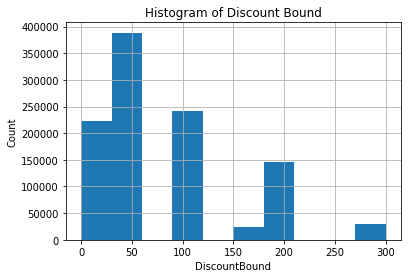

In [24]:
#Check the data distribution fitst
total_df['DiscountBound'].hist()
plt.title('Histogram of Discount Bound')
plt.xlabel('DiscountBound')
plt.ylabel('Count')
plt.show()

In [25]:
cuttingArr = np.array([-1,80,150,250,total_df.DiscountBound.max()+1])
total_df['DiscountBound_Group'] = pd.cut(total_df.DiscountBound, cuttingArr)

print(total_df.DiscountBound_Group.value_counts())
print('\n')
#encoding intervals into integer
DiscountBound_intervals = total_df.DiscountBound_Group.unique()
total_df.DiscountBound_Group.replace(to_replace = DiscountBound_intervals[0],value = 0, inplace = True)
total_df.DiscountBound_Group.replace(to_replace = DiscountBound_intervals[1],value = 1, inplace = True)
total_df.DiscountBound_Group.replace(to_replace = DiscountBound_intervals[2],value = 2, inplace = True)
total_df.DiscountBound_Group.replace(to_replace = DiscountBound_intervals[3],value = 3, inplace = True)
print(total_df.DiscountBound_Group.value_counts())

(-1, 80]      611276
(80, 150]     266140
(150, 250]    146602
(250, 301]     29264
Name: DiscountBound_Group, dtype: int64


0    611276
2    266140
1    146602
3     29264
Name: DiscountBound_Group, dtype: int64


User id features
I would like to use User_id feature to group with other features. I hope this can find some characteristic or behavior of user

In [26]:
Same_Merchant_User_received = total_df[['User_id','Merchant_id']]
Same_Merchant_User_received['temp'] = 1
Same_Merchant_User_received = Same_Merchant_User_received.groupby(['User_id','Merchant_id']).agg('sum').reset_index()
Same_Merchant_User_received.columns = ['User_id','Merchant_id','Same_Merchant_User_received']

total_df = pd.merge(total_df, Same_Merchant_User_received, on = ['User_id','Merchant_id'], how = 'left')

Record how many coupons each user received

In [29]:
Total_Coupon_User_received = total_df.groupby(['User_id'])['Coupon_id'].count().reset_index()
Total_Coupon_User_received.columns = ['User_id', 'Total_Coupon_User_received']
total_df = pd.merge(total_df,Total_Coupon_User_received, on = ['User_id'], how = 'left')

Record how many same coupons each user received

In [30]:
Same_Coupon_User_received = total_df[['User_id', 'Coupon_id']]
Same_Coupon_User_received['temp'] = 1
Same_Coupon_User_received = Same_Coupon_User_received.groupby(['User_id','Coupon_id']).agg('sum').reset_index()
Same_Coupon_User_received.columns = ['User_id','Coupon_id','Same_Coupon_User_received']

total_df = pd.merge(total_df,Same_Coupon_User_received , on = ['User_id', 'Coupon_id'], how = 'left')

Record how many same coupons each user received at the same day

In [31]:
Same_Day_Same_Coupon_User_received = total_df[['User_id','Coupon_id','Date_received']]
Same_Day_Same_Coupon_User_received['temp'] = 1
Same_Day_Same_Coupon_User_received = Same_Day_Same_Coupon_User_received.groupby(['User_id','Coupon_id','Date_received']).agg('sum').reset_index()
Same_Day_Same_Coupon_User_received.columns = ['User_id','Coupon_id','Date_received','Same_Day_Same_Coupon_User_received']

total_df = pd.merge(total_df, Same_Day_Same_Coupon_User_received , on = ['User_id','Coupon_id','Date_received'], how = 'left')

Record how many coupons each user received at the same day

In [33]:
Same_Day_Total_Coupon_User_received = total_df[['User_id','Date_received']]
Same_Day_Total_Coupon_User_received['temp'] = 1
Same_Day_Total_Coupon_User_received = Same_Day_Total_Coupon_User_received.groupby(['User_id','Date_received']).agg('sum').reset_index()
Same_Day_Total_Coupon_User_received.columns = ['User_id','Date_received', 'Same_Day_Total_Coupon_User_received']

total_df = pd.merge(total_df, Same_Day_Total_Coupon_User_received, on = ['User_id', 'Date_received'], how ='left')

Record the mean/max/min discount upper bound of coupon that each user received

In [34]:
User_Received_Coupon_DistcountBound_Mean = total_df.groupby(['User_id'])['DiscountBound'].mean().reset_index()
User_Received_Coupon_DistcountBound_Mean.columns = ['User_id','User_Received_Coupon_DistcountBound_Mean']

User_Received_Coupon_DistcountBound_Max = total_df.groupby(['User_id'])['DiscountBound'].max().reset_index()
User_Received_Coupon_DistcountBound_Max.columns = ['User_id','User_Received_Coupon_DistcountBound_Max']

User_Received_Coupon_DistcountBound_Min = total_df.groupby(['User_id'])['DiscountBound'].min().reset_index()
User_Received_Coupon_DistcountBound_Min.columns = ['User_id','User_Received_Coupon_DistcountBound_Min']

total_df = pd.merge(total_df,User_Received_Coupon_DistcountBound_Mean, on = ['User_id'], how = 'left')
total_df = pd.merge(total_df,User_Received_Coupon_DistcountBound_Max, on = ['User_id'], how = 'left')
total_df = pd.merge(total_df,User_Received_Coupon_DistcountBound_Min, on = ['User_id'], how = 'left')

Record the mean/max/min Money Cost of coupon that each user received

In [36]:
User_Received_Coupon_MoneyCost_Mean = total_df.groupby(['User_id'])['MoneyCost'].mean().reset_index()
User_Received_Coupon_MoneyCost_Mean.columns = ['User_id','User_Received_Coupon_MoneyCost_Mean']

User_Received_Coupon_MoneyCost_Max = total_df.groupby(['User_id'])['MoneyCost'].max().reset_index()
User_Received_Coupon_MoneyCost_Max.columns = ['User_id','User_Received_Coupon_MoneyCost_Max']

User_Received_Coupon_MoneyCost_Min = total_df.groupby(['User_id'])['MoneyCost'].min().reset_index()
User_Received_Coupon_MoneyCost_Min.columns = ['User_id','User_Received_Coupon_MoneyCost_Min']

total_df = pd.merge(total_df,User_Received_Coupon_MoneyCost_Mean, on = ['User_id'], how = 'left')
total_df = pd.merge(total_df,User_Received_Coupon_MoneyCost_Max, on = ['User_id'], how = 'left')
total_df = pd.merge(total_df,User_Received_Coupon_MoneyCost_Min, on = ['User_id'], how = 'left')

Record the mean discount ratio of coupon that each user received

In [37]:
User_Received_Coupon_DiscountRatio_Mean = total_df.groupby(['User_id'])['DiscountRatio'].mean().reset_index()
User_Received_Coupon_DiscountRatio_Mean.columns = ['User_id','User_Received_Coupon_DiscountRatio_Mean']
total_df = pd.merge(total_df,User_Received_Coupon_DiscountRatio_Mean, on = ['User_id'], how = 'left')

Record the minimal days that user received the same coupon. If the user only got the coupon once, then make the day gaps big.

In [38]:
#This will take a long~ time
def CalMinReceivedGap(data):

    dates = data.split(':')
    if len(dates) == 1:
        return -1 #Means only received once
    MinGap = 365
    for i in range(0,len(dates)-1):
        cur_gap = pd.to_datetime( dates[i] , format = "%Y-%m-%d") - pd.to_datetime(dates[i+1] , format = "%Y-%m-%d")
        cur_gap = abs(cur_gap.days)
        if cur_gap < MinGap:
                MinGap = cur_gap
    return MinGap

Min_Coupon_received_gap = total_df[['User_id','Coupon_id','Date_received']]
Min_Coupon_received_gap.Date_received = Min_Coupon_received_gap.Date_received.astype('str')
Min_Coupon_received_gap =  Min_Coupon_received_gap.groupby(['User_id','Coupon_id'])['Date_received'].agg(lambda x : ':'.join(x)).reset_index()
Min_Coupon_received_gap['Min_Coupon_received_gap'] = Min_Coupon_received_gap.Date_received.apply(CalMinReceivedGap)
Min_Coupon_received_gap = Min_Coupon_received_gap.drop(['Date_received'], axis = 1)

total_df = pd.merge(total_df,Min_Coupon_received_gap,on = ['User_id','Coupon_id'], how ='left')
max_received_gap = total_df.Min_Coupon_received_gap.max()
total_df.Min_Coupon_received_gap = total_df.Min_Coupon_received_gap.map(lambda x : x if x != -1 else max_received_gap)

ValueError: time data 20160129.0 doesn't match format specified

Record the maximum days that user received the same coupon. If the user only got the coupon once, then make the day gaps big.

In [ ]:
def CalMaxReceivedGap(data):
    dates = data.split(':')
    if len(dates) == 1:
        return -1 #Means only received once
    MaxGap = 0
    for i in range(0,len(dates)-1):
        cur_gap = pd.to_datetime( dates[i] , format = "%Y-%m-%d") - pd.to_datetime(dates[i+1] , format = "%Y-%m-%d")
        cur_gap = abs(cur_gap.days)
        if cur_gap > MaxGap:
                MaxGap = cur_gap
    return MaxGap


Max_Coupon_received_gap = total_df[['User_id','Coupon_id','Date_received']]
Max_Coupon_received_gap.Date_received = Max_Coupon_received_gap.Date_received.astype('str')
Max_Coupon_received_gap =  Max_Coupon_received_gap.groupby(['User_id','Coupon_id'])['Date_received'].agg(lambda x : ':'.join(x)).reset_index()
Max_Coupon_received_gap['Max_Coupon_received_gap'] = Max_Coupon_received_gap.Date_received.apply(CalMaxReceivedGap)
Max_Coupon_received_gap = Max_Coupon_received_gap.drop(['Date_received'], axis = 1)

total_df = pd.merge(total_df,Max_Coupon_received_gap,on = ['User_id','Coupon_id'], how ='left')
max_received_gap = total_df.Max_Coupon_received_gap.max()
total_df.Max_Coupon_received_gap = total_df.Max_Coupon_received_gap.map(lambda x : x if x != -1 else max_received_gap)
total_df.head(10)

Merchant features

Here I will use Merchant_id feature to group with other features. This just vey similar to the processing of User_id feature.

In [40]:
Merchant_DiscountBound_mean = total_df.groupby(['Merchant_id'])['DiscountBound'].mean().reset_index()
Merchant_DiscountBound_mean.columns = ['Merchant_id','Merchant_DiscountBound_mean']

Merchant_DiscountBound_max = total_df.groupby(['Merchant_id'])['DiscountBound'].max().reset_index()
Merchant_DiscountBound_max.columns = ['Merchant_id','Merchant_DiscountBound_max']

Merchant_DiscountBound_min = total_df.groupby(['Merchant_id'])['DiscountBound'].min().reset_index()
Merchant_DiscountBound_min.columns = ['Merchant_id','Merchant_DiscountBound_min']

Merchant_DiscountRatio_max = total_df.groupby(['Merchant_id'])['DiscountRatio'].max().reset_index()
Merchant_DiscountRatio_max.columns = ['Merchant_id','Merchant_DiscountRatio_max']

Merchant_DiscountRatio_min = total_df.groupby(['Merchant_id'])['DiscountRatio'].min().reset_index()
Merchant_DiscountRatio_min.columns = ['Merchant_id','Merchant_DiscountRatio_min']

Merchant_DirectPriceCut_max = total_df.groupby(['Merchant_id'])['DirectPriceCut'].max().reset_index()
Merchant_DirectPriceCut_max.columns = ['Merchant_id','Merchant_DirectPriceCut_max']

Merchant_DirectPriceCut_min = total_df.groupby(['Merchant_id'])['DirectPriceCut'].min().reset_index()
Merchant_DirectPriceCut_min.columns = ['Merchant_id','Merchant_DirectPriceCut_min']

Merchant_DirectPriceCut_mean = total_df.groupby(['Merchant_id'])['DirectPriceCut'].mean().reset_index()
Merchant_DirectPriceCut_mean.columns = ['Merchant_id', 'Merchant_DirectPriceCut_mean']

Merchant_MoneyCost_mean = total_df.groupby(['Merchant_id'])['MoneyCost'].mean().reset_index()
Merchant_MoneyCost_mean.columns = ['Merchant_id', 'Merchant_MoneyCost_mean']

Merchant_MoneyCost_max = total_df.groupby(['Merchant_id'])['MoneyCost'].max().reset_index()
Merchant_MoneyCost_max.columns = ['Merchant_id', 'Merchant_MoneyCost_max']

Merchant_MoneyCost_min = total_df.groupby(['Merchant_id'])['MoneyCost'].min().reset_index()
Merchant_MoneyCost_min.columns = ['Merchant_id', 'Merchant_MoneyCost_min']

total_df = pd.merge(total_df,Merchant_DiscountBound_mean,on = ['Merchant_id'], how = 'left')
total_df = pd.merge(total_df,Merchant_DirectPriceCut_mean,on = ['Merchant_id'], how = 'left')
total_df = pd.merge(total_df,Merchant_MoneyCost_mean,on = ['Merchant_id'], how = 'left')
total_df = pd.merge(total_df,Merchant_DiscountBound_max, on = ['Merchant_id'], how = 'left')
total_df = pd.merge(total_df,Merchant_DiscountBound_min, on = ['Merchant_id'], how = 'left')
total_df = pd.merge(total_df,Merchant_DiscountRatio_max, on = ['Merchant_id'], how = 'left')
total_df = pd.merge(total_df,Merchant_DiscountRatio_min, on = ['Merchant_id'], how = 'left')
total_df = pd.merge(total_df,Merchant_DirectPriceCut_max, on = ['Merchant_id'], how = 'left')
total_df = pd.merge(total_df,Merchant_DirectPriceCut_min, on = ['Merchant_id'], how = 'left')
total_df = pd.merge(total_df,Merchant_MoneyCost_max, on = ['Merchant_id'], how = 'left')
total_df = pd.merge(total_df,Merchant_MoneyCost_min, on = ['Merchant_id'], how = 'left')

In [41]:
Mcount = total_df.Merchant_id.value_counts().reset_index()
Mcount.columns = ['Merchant_id','Merchant_count']
Ccount = total_df.Coupon_id.value_counts().reset_index()
Ccount.columns = ['Coupon_id','Coupon_count']

total_df = pd.merge(total_df,Mcount,on = ['Merchant_id'], how = 'left')
total_df = pd.merge(total_df,Ccount,on = ['Coupon_id'], how = 'left')

Let check the correlation between label and features to judge what we just did is good or not

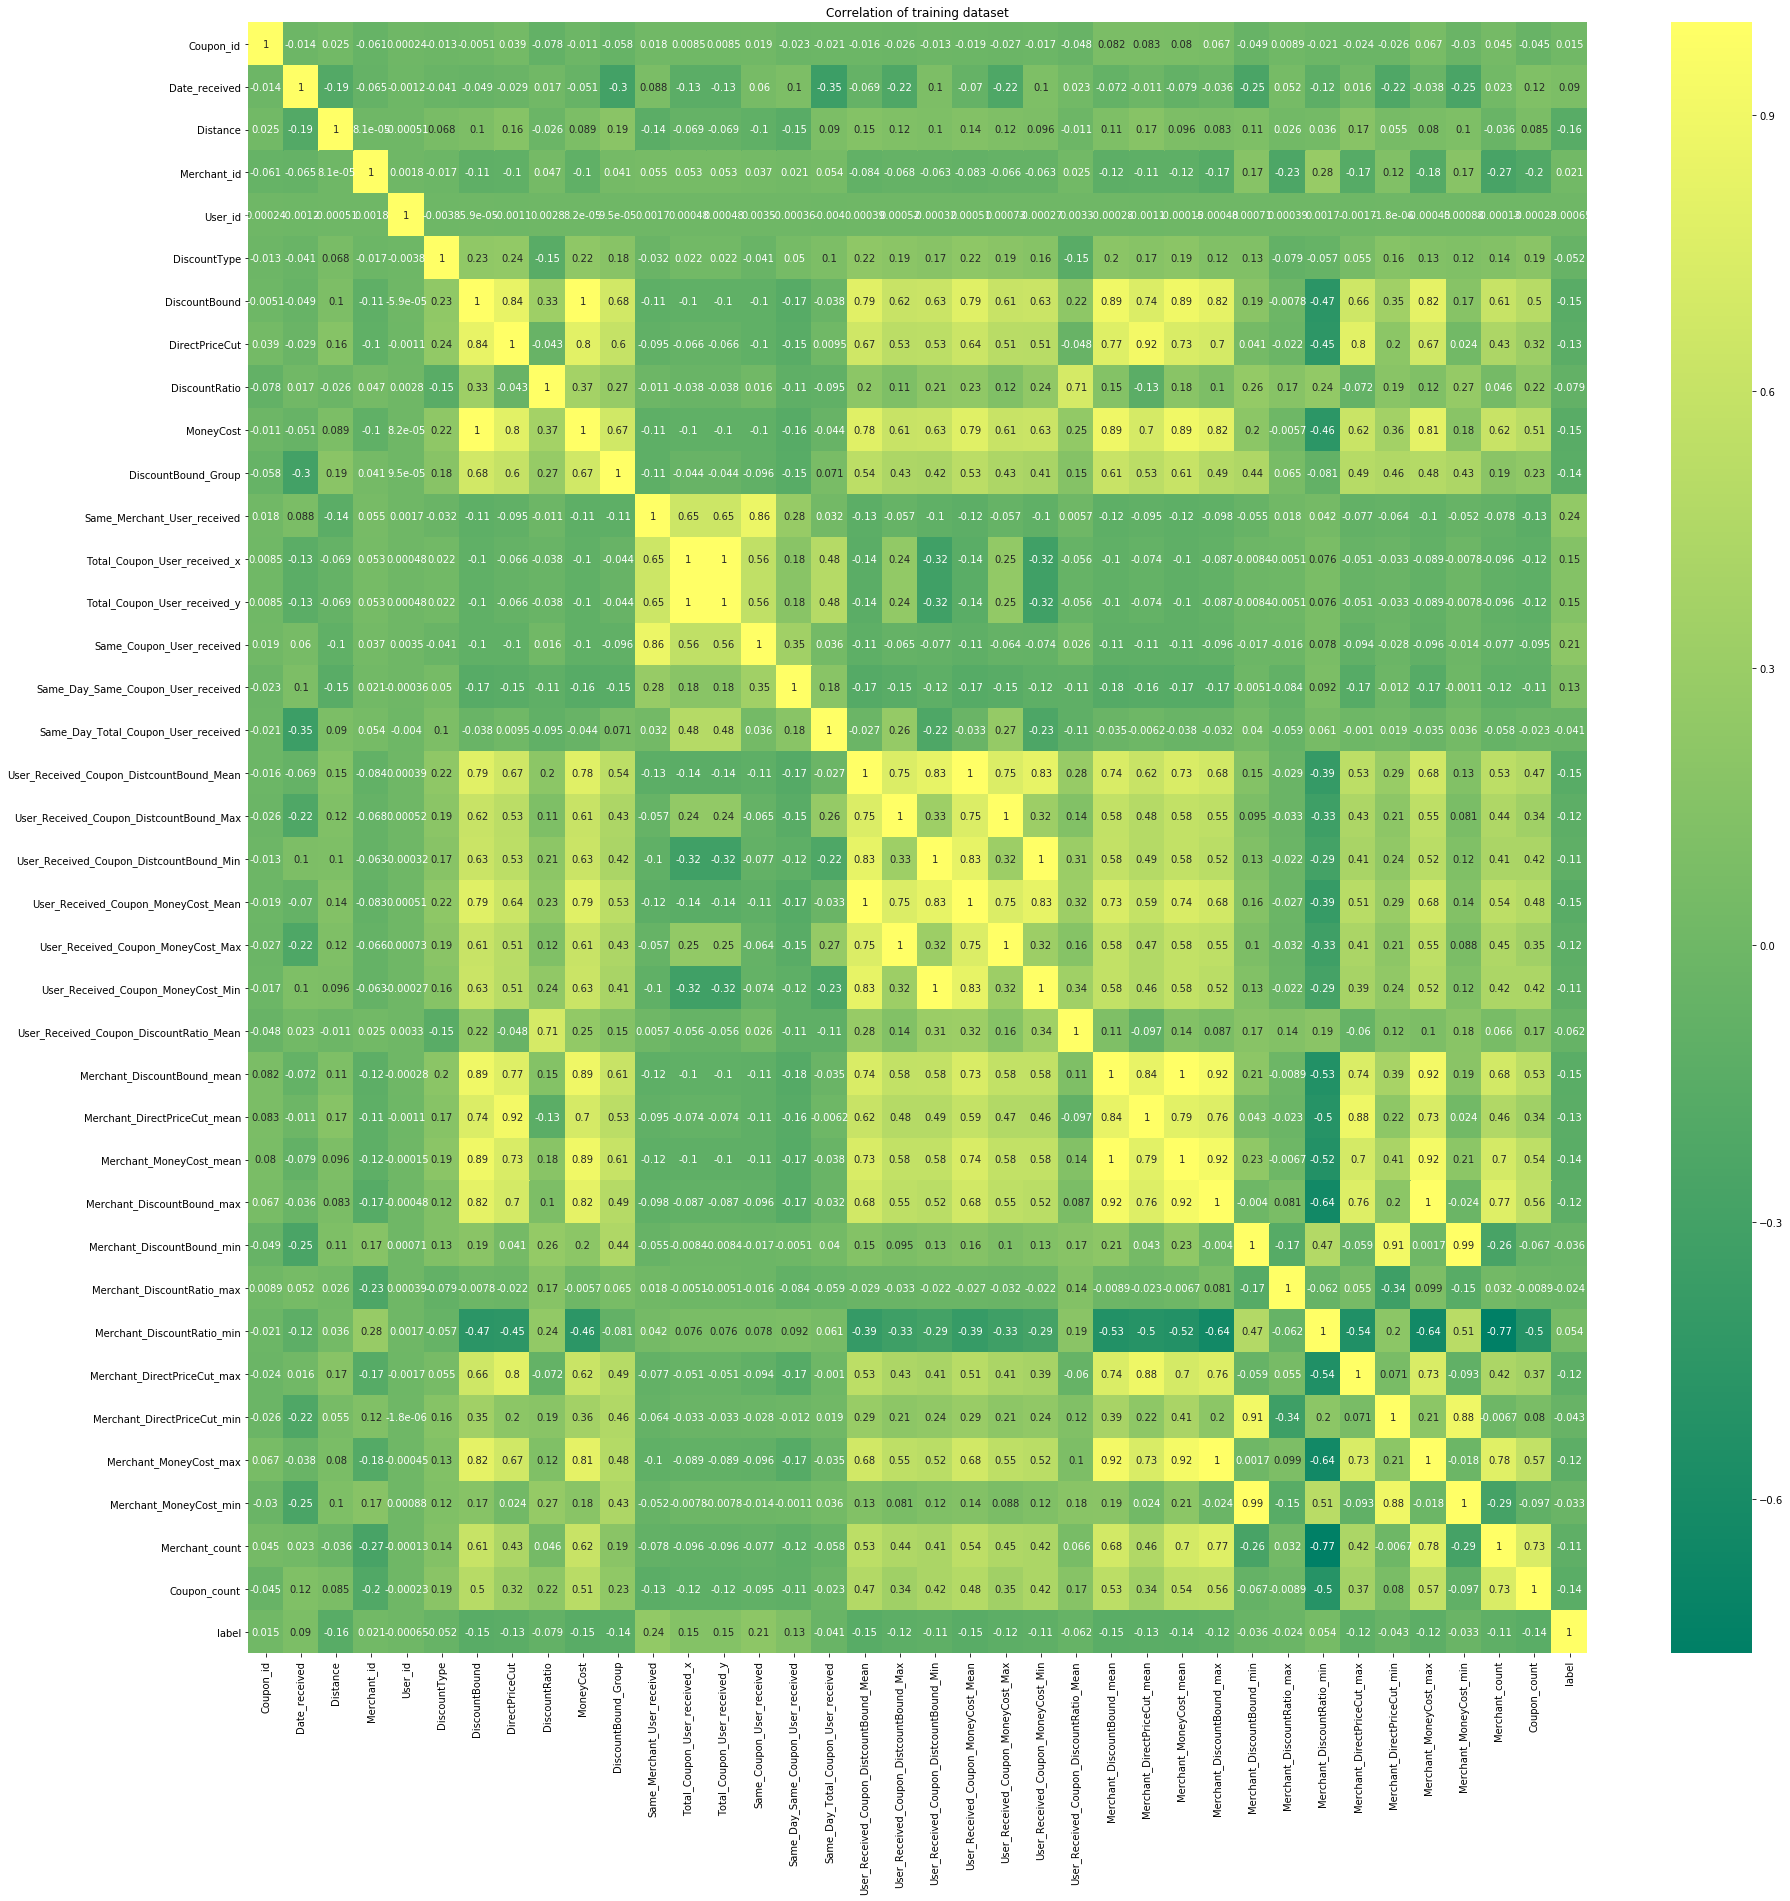

In [42]:
#Check the correlation again before fill the missing values of Distance
correlation = copy.deepcopy(total_df[:len(train_df)])
correlation = pd.concat([correlation, pd.DataFrame(train_label.values, columns = ['label'], index = correlation.index)], axis = 1)
corr = correlation.corr()
plt.figure(figsize = (30,30))
sns.heatmap(corr, cmap = plt.cm.summer, annot = True)
plt.title('Correlation of training dataset')
plt.show()


Distance features

In [43]:
#There are still some Distance values missing
#Let's check the ratio between missing values and non-missing values

print(f' Missing ratio of Distance : {np.sum(total_df.Distance.isnull()) / len(total_df)}')

 Missing ratio of Distance : 0.008023492284117644


I have a bold idea, the distance might will have little correlation of when user received the coupon. Since the merchant might would send the coupon in certain days. So If there are some users received the coupon at similar time, they might had got the coupon at the same merchant. Which means it has slightly chance that these users have similar event location.

In [45]:
total_df['Distance'] = total_df.groupby(['CloseToJune'])['Distance'].transform(lambda x : x.fillna(x.mode()[0]))
CheckMissingVals(total_df)
total_df.head(10)

KeyError: 'CloseToJune'

In [46]:
User_Activity_Distance_Mean = total_df.groupby(['User_id'])['Distance'].mean().reset_index()
User_Activity_Distance_Mean.columns = ['User_id','User_Activity_Distance_Mean']
total_df = pd.merge(total_df,User_Activity_Distance_Mean,on = ['User_id'], how = 'left')

User_Activity_Distance_Max = total_df.groupby(['User_id'])['Distance'].max().reset_index()
User_Activity_Distance_Max.columns = ['User_id','User_Activity_Distance_Max']
total_df = pd.merge(total_df,User_Activity_Distance_Max,on = ['User_id'], how = 'left')

User_Activity_Distance_Min = total_df.groupby(['User_id'])['Distance'].min().reset_index()
User_Activity_Distance_Min.columns = ['User_id','User_Activity_Distance_Min']
total_df = pd.merge(total_df,User_Activity_Distance_Min,on = ['User_id'], how = 'left')
total_df['Bound_Distance'] = total_df['DiscountBound']+1 * (total_df['Distance']+1)
total_df['DiscountRatio_Distance'] = total_df['DiscountRatio'] * (total_df['Distance']+1)
total_df['MoneyCost_Distance'] = total_df['MoneyCost']+1 * (total_df['Distance']+1)
total_df['DirectPriceCut_Distance'] = total_df['DirectPriceCut']+1 / (total_df['Distance']+1) 
Merchant_Distance_mean = total_df.groupby(['Merchant_id'])['Distance'].mean().reset_index()
Merchant_Distance_mean.columns = ['Merchant_id','Merchant_Distance_mean']

Merchant_Distance_max = total_df.groupby(['Merchant_id'])['Distance'].max().reset_index()
Merchant_Distance_max.columns = ['Merchant_id','Merchant_Distance_max']

Merchant_Distance_min = total_df.groupby(['Merchant_id'])['Distance'].min().reset_index()
Merchant_Distance_min.columns = ['Merchant_id','Merchant_Distance_min']


Coupon_Distance_mean = total_df.groupby(['Coupon_id'])['Distance'].mean().reset_index()
Coupon_Distance_mean.columns = ['Coupon_id', 'Coupon_Distance_mean']

Coupon_Distance_max = total_df.groupby(['Coupon_id'])['Distance'].max().reset_index()
Coupon_Distance_max.columns = ['Coupon_id', 'Coupon_Distance_max']

Coupon_Distance_min = total_df.groupby(['Coupon_id'])['Distance'].min().reset_index()
Coupon_Distance_min.columns = ['Coupon_id', 'Coupon_Distance_min']
total_df = pd.merge(total_df,Merchant_Distance_mean,on = ['Merchant_id'], how = 'left')
total_df = pd.merge(total_df,Merchant_Distance_max,on = ['Merchant_id'], how = 'left')
total_df = pd.merge(total_df,Merchant_Distance_min,on = ['Merchant_id'], how = 'left')

total_df = pd.merge(total_df,Coupon_Distance_mean, on = ['Coupon_id'], how = 'left')
total_df = pd.merge(total_df,Coupon_Distance_max, on = ['Coupon_id'], how = 'left')
total_df = pd.merge(total_df,Coupon_Distance_min, on = ['Coupon_id'], how = 'left')


Features encoding with label

In [47]:
'''
trainSet = copy.deepcopy(total_df[:len(train_df)])
trainSet = pd.concat([trainSet, pd.DataFrame(train_label.values, columns = ['label'], index = trainSet.index)], axis = 1)
trainSet.head(3)
'''
'''
Distance_Accepted_rate = trainSet.groupby(['Distance'])['label'].mean().reset_index()
Distance_Accepted_rate.columns = ['Distance','Distance_Accepted_rate']

DiscountBound_Accepted_rate = trainSet.groupby(['DiscountBound'])['label'].mean().reset_index()
DiscountBound_Accepted_rate.columns = ['DiscountBound', 'DiscountBound_Accepted_rate']

total_df = pd.merge(total_df, Distance_Accepted_rate , on = ['Distance'], how = 'left')
total_df = pd.merge(total_df, DiscountBound_Accepted_rate, on = ['DiscountBound'], how = 'left')

total_df.head(5)
'''

"\nDistance_Accepted_rate = trainSet.groupby(['Distance'])['label'].mean().reset_index()\nDistance_Accepted_rate.columns = ['Distance','Distance_Accepted_rate']\n\nDiscountBound_Accepted_rate = trainSet.groupby(['DiscountBound'])['label'].mean().reset_index()\nDiscountBound_Accepted_rate.columns = ['DiscountBound', 'DiscountBound_Accepted_rate']\n\ntotal_df = pd.merge(total_df, Distance_Accepted_rate , on = ['Distance'], how = 'left')\ntotal_df = pd.merge(total_df, DiscountBound_Accepted_rate, on = ['DiscountBound'], how = 'left')\n\ntotal_df.head(5)\n"

Scale the features

In [48]:
total_df = total_df.drop(['Merchant_id','Coupon_id','Day_received','Month_received','User_id','Date_received'],axis = 1)

KeyError: "labels ['Day_received' 'Month_received'] not contained in axis"

In [49]:
for col in total_df.columns:
    if (col != 'Distance_Accepted_rate') & (col != 'DiscountBound_Accepted_rate'):
        total_df[col] = MinMaxScaler().fit_transform(total_df[col].values.reshape(-1,1))        
total_df.head(10)
Distance	Month_Cycle	CloseToJune	DiscountType	DiscountBound	DirectPriceCut	DiscountRatio	MoneyCost	DiscountBound_Group	Same_Merchant_User_received	Total_Coupon_User_received	Same_Coupon_User_received	

SyntaxError: invalid syntax (<ipython-input-49-e980c133d790>, line 5)

In [50]:
#One hot encoding the discount type
total_df = pd.get_dummies(total_df, columns = ['DiscountType'], prefix = "DiscountType")
print(f' final shape of total data : {total_df.shape} ')


 final shape of total data : (1053282, 51) 


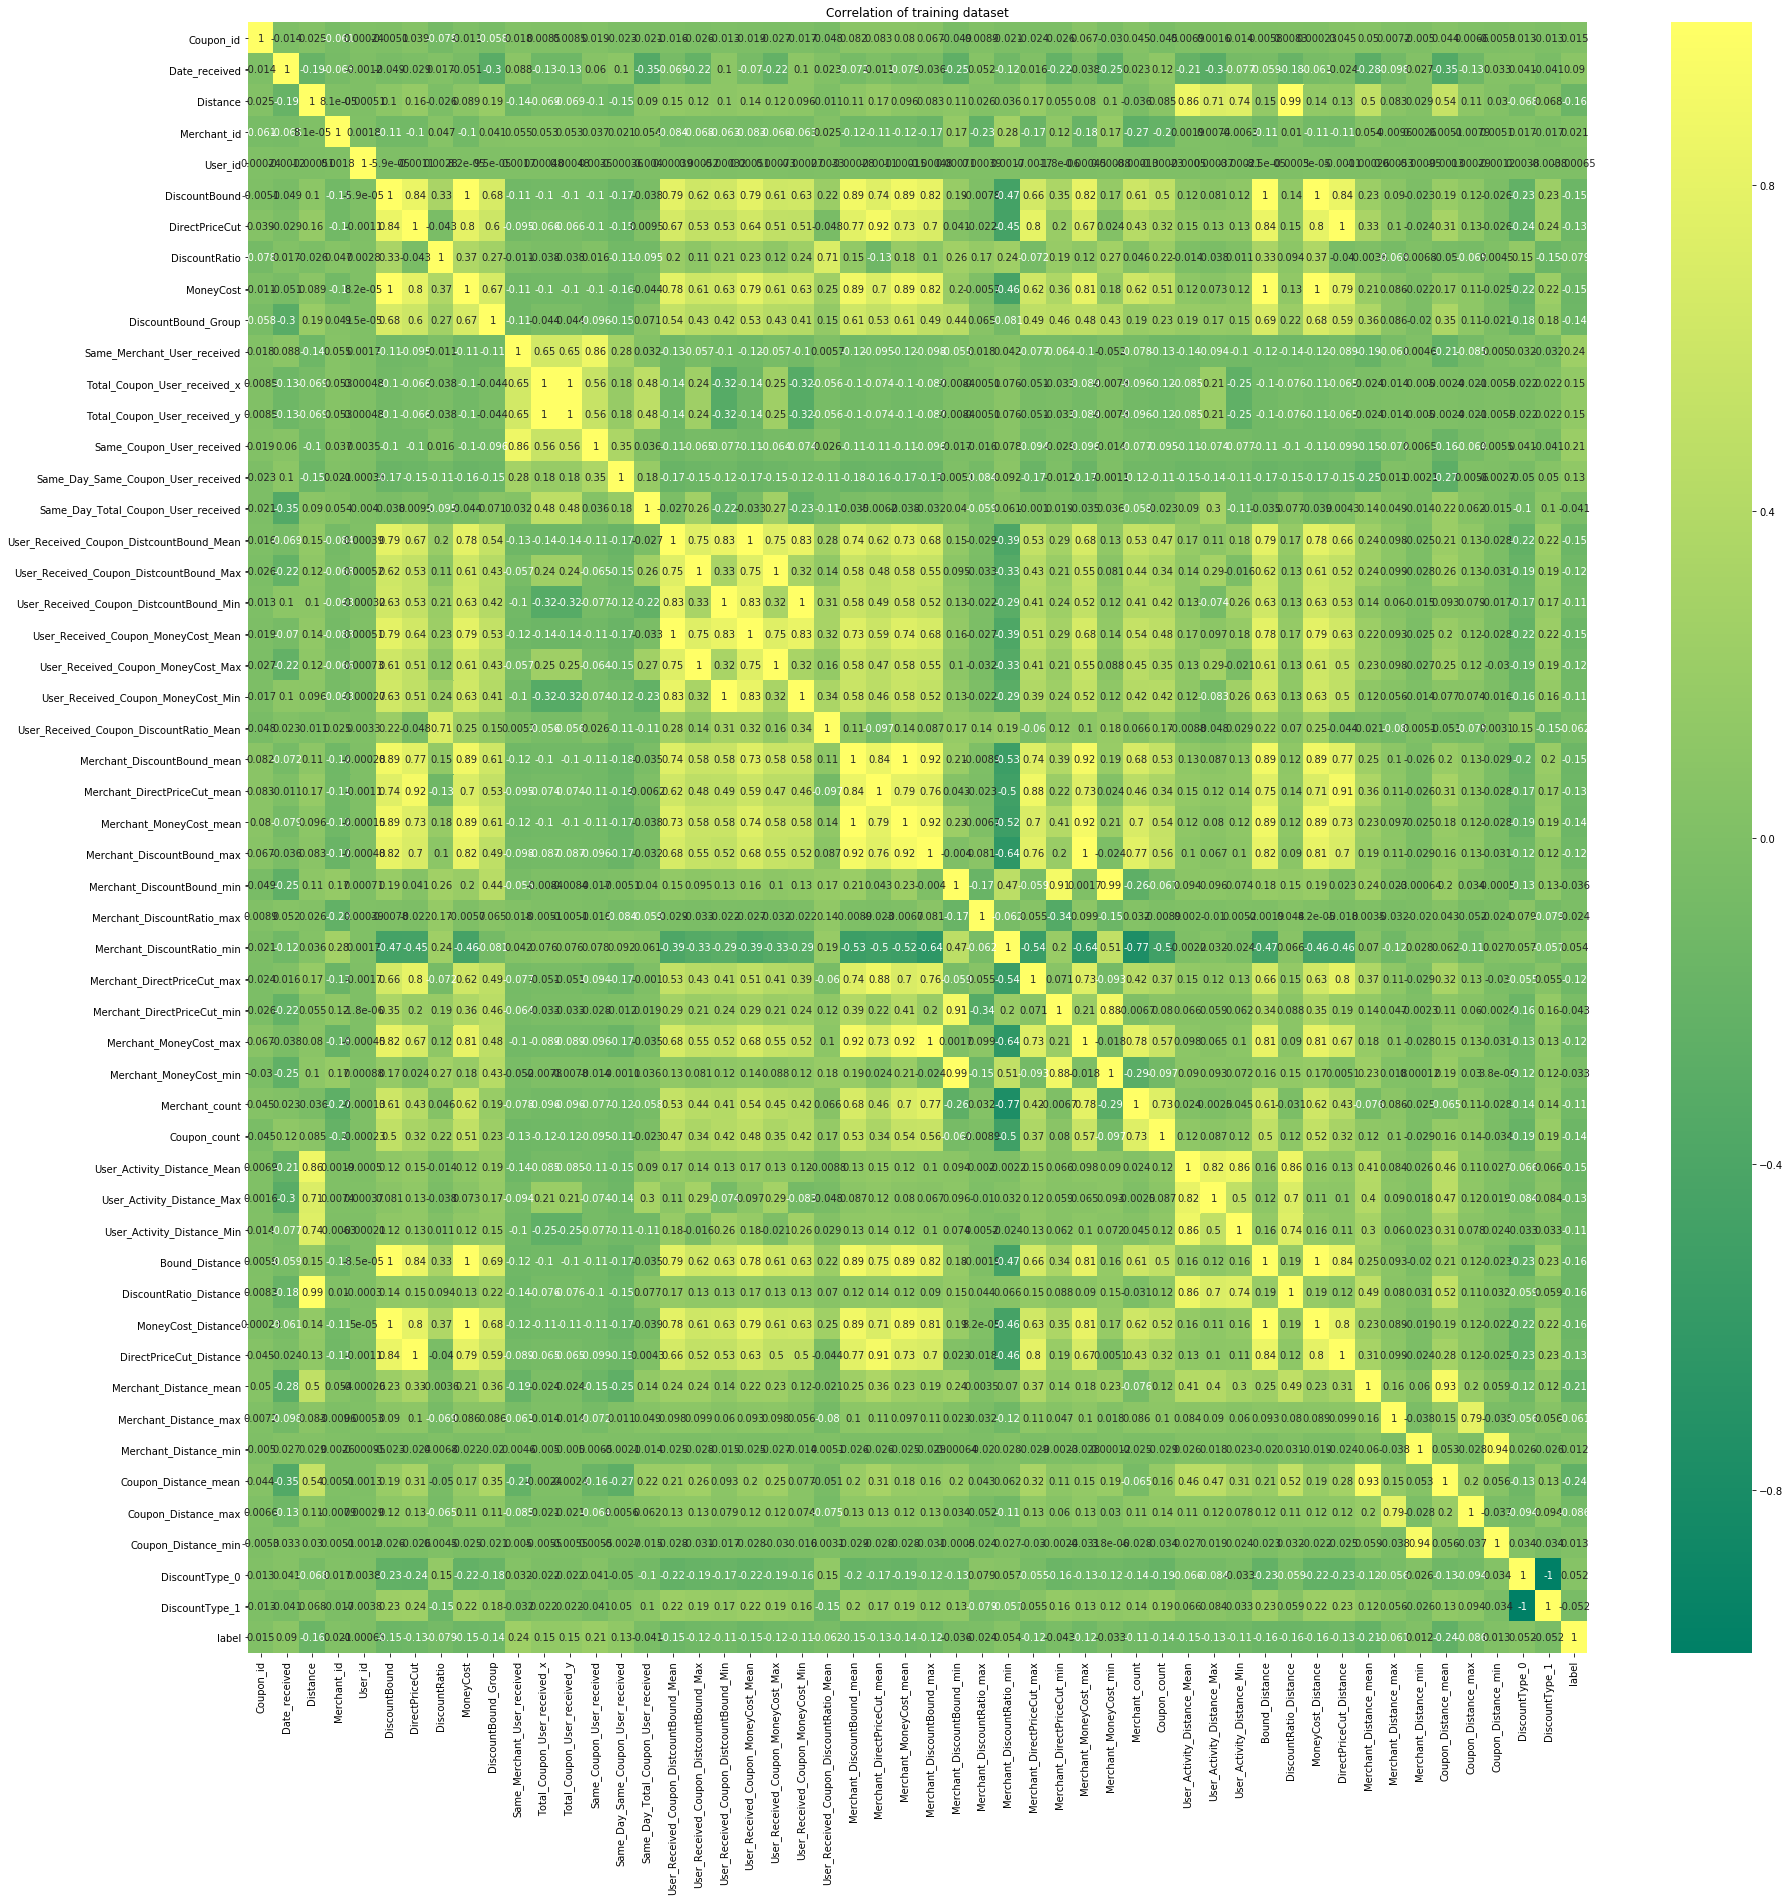

In [51]:
#Check the correlation again before fill the missing values of Distance
correlation = copy.deepcopy(total_df[:len(train_df)])
correlation = pd.concat([correlation, pd.DataFrame(train_label.values, columns = ['label'], index = correlation.index)], axis = 1)
corr = correlation.corr()
plt.figure(figsize = (30,30))
sns.heatmap(corr, cmap = plt.cm.summer, annot = True)
plt.title('Correlation of training dataset')
plt.show()

Model training & validation¶

In [ ]:
train_x = total_df[:len(train_df)]
test_x = total_df[len(train_df):]

def tuneParamsRandom(classifier, params, train_x, train_y, cv = 5):
    rs = RandomizedSearchCV(classifier, params, n_iter = 20, scoring = 'roc_auc', n_jobs = -1, verbose = 0, cv=cv)
    rs.fit(train_x, train_y)
    
    return rs.best_params_, abs(rs.best_score_)

In [53]:
etParams = {'n_estimators':np.arange(100,1100,50), 'max_depth':np.arange(3,11,2),
            'min_samples_leaf':np.arange(1,6,2) }

rfParams = {'n_estimators':np.arange(100,1100,50), 'max_depth':np.arange(3,11,2),
            'min_samples_split':np.arange(2,20,2), 'min_samples_leaf':np.arange(1,6,2) }

abParams = {'n_estimators':np.arange(100,1100,50),'learning_rate':np.arange(0.01,0.2,0.05)}


lgbmcParams = {'n_estimators' : np.arange(400,1200,100), 'learning_rate' : np.arange(0.01,0.1,0.02),
               'num_leaves' : np.arange(2,48,4), 'max_depth' : np.arange(3,10,2),
               'subsample' : np.arange(0.3,0.8,0.1) }

gbcParams = {'n_estimators' : np.arange(400,1200,100) , 'learning_rate' : np.arange(0.01,0.1,0.02) 
             , 'min_samples_split' : np.arange(2,30,5), 'min_samples_leaf' : np.arange(2,32,4),
              'max_depth' : np.arange(3,8,2), 'subsample' : np.arange(0.3,0.8,0.1)}

xgbParams = {'max_depth':np.arange(3,8,1),'learning_rate':np.arange(0.01,0.1,0.02)
             ,'n_estimator': np.arange(1000,3000,100),'gamma':np.arange(0.01,0.1,0.02)}

lrParams = {'C':np.arange(0.01,1,0.05), 'max_iter' : np.arange(100,500,100)}

In [54]:
train_label.index = train_x.index
tuneSet = pd.concat([train_x,train_label], axis = 1)
trainSet = tuneSet.sample(frac=0.5)
trainSet.shape

NameError: name 'train_x' is not defined

In [55]:
x_train, x_test, y_train, y_test = train_test_split(trainSet[trainSet.columns[trainSet.columns != 'label']],trainSet['label'], test_size = 0.3, random_state = 1234)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

NameError: name 'trainSet' is not defined

LogisticRegression

In [56]:
'''
lr = LogisticRegression(random_state = 2019,n_jobs = -1)
lr_best_Params, lr_best_score = tuneParamsRandom(lr,lrParams,x_train,y_train)
print("LogisticRegression :",lr_best_Params,lr_best_score)
lr = LogisticRegression(**lr_best_Params,n_jobs = -1)
lr.fit(x_train,y_train)
lr_pred_val = lr.predict_proba(x_test)
auc_score = roc_auc_score(y_true = y_test, y_score = lr_pred_val[:,1])
acc = accuracy_score(y_true = y_test, y_pred = lr_pred_val.argmax(axis=1))
print("Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))
lr = LogisticRegression(**lr_best_Params,n_jobs = -1,random_state = 2019)
lr.fit(train_x, train_label)
lr_pred = lr.predict_proba(test_x)[:,1]
'''

'\nlr = LogisticRegression(random_state = 2019,n_jobs = -1)\nlr_best_Params, lr_best_score = tuneParamsRandom(lr,lrParams,x_train,y_train)\nprint("LogisticRegression :",lr_best_Params,lr_best_score)\nlr = LogisticRegression(**lr_best_Params,n_jobs = -1)\nlr.fit(x_train,y_train)\nlr_pred_val = lr.predict_proba(x_test)\nauc_score = roc_auc_score(y_true = y_test, y_score = lr_pred_val[:,1])\nacc = accuracy_score(y_true = y_test, y_pred = lr_pred_val.argmax(axis=1))\nprint("Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))\nlr = LogisticRegression(**lr_best_Params,n_jobs = -1,random_state = 2019)\nlr.fit(train_x, train_label)\nlr_pred = lr.predict_proba(test_x)[:,1]\n'

LGBMClassifier

In [57]:
lgbmc_best_Params, lgbmc_best_score = tuneParamsRandom(LGBMClassifier(),lgbmcParams,x_train,y_train)
print("LGBMClassifier:",lgbmc_best_Params,lgbmc_best_score)


lgbmc = LGBMClassifier(**lgbmc_best_Params)
lgbmc.fit(train_x,train_label)
lgbmc_pred = lgbmc.predict_proba(test_x)[:,1]

NameError: name 'tuneParamsRandom' is not defined

In [58]:
Blending

NameError: name 'Blending' is not defined

In [59]:
#blending_pred = gbc_pred * 0.3 + lgbmc_pred * 0.7 

In [60]:
Stacking

NameError: name 'Stacking' is not defined

In [61]:
'''
from mlxtend.classifier import StackingClassifier
gbc = GradientBoostingClassifier(**gbc_best_Params)
lgbmc = LGBMClassifier(**lgbmc_best_Params)
xgb = XGBClassifier(**xgb_best_Params)

meta_estimator = LGBMClassifier()
stacking = StackingClassifier(classifiers = [gbc,lgbmc, xgb], meta_classifier = meta_estimator)
stacking.fit(train_x,train_label)
stacking_pred = stacking.predict_proba(test_x)[:,1]
'''

'\nfrom mlxtend.classifier import StackingClassifier\ngbc = GradientBoostingClassifier(**gbc_best_Params)\nlgbmc = LGBMClassifier(**lgbmc_best_Params)\nxgb = XGBClassifier(**xgb_best_Params)\n\nmeta_estimator = LGBMClassifier()\nstacking = StackingClassifier(classifiers = [gbc,lgbmc, xgb], meta_classifier = meta_estimator)\nstacking.fit(train_x,train_label)\nstacking_pred = stacking.predict_proba(test_x)[:,1]\n'

In [62]:
Submission

NameError: name 'Submission' is not defined

In [63]:
test_ids = test_ids.loc[~test_ids.Coupon_id.isna()]

test_ids = pd.concat([test_ids, pd.DataFrame(lgbmc_pred, columns = ['label'], index = test_ids.index)] , axis = 1)

test_ids.loc[:,"User_id"] = test_ids["User_id"].apply(lambda x:str(int(x)))
test_ids.loc[:,"Coupon_id"] = test_ids["Coupon_id"].apply(lambda x:str(int(x)))
test_ids.loc[:,"Date_received"] = test_ids["Date_received"].apply(lambda x: str(int(x)))

test_ids["uid"] = test_ids[['User_id',"Coupon_id","Date_received"]].apply(lambda x: '_'.join(x.values), axis = 1)
test_ids.reset_index(drop = True, inplace = True)


NameError: name 'lgbmc_pred' is not defined

In [64]:
submission = test_ids.groupby("uid", as_index = False).mean()
submission = submission[["uid","label"]]
submission.to_csv("v9.csv", header = ["uid", "label"], index = False)

submission.head(10)

KeyError: 'uid'